In [34]:
import numpy as np
import os
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform

from keras import layers, models
from keras.callbacks import EarlyStopping
from keras.models import save_model
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
from helpers import *

# Description

## Strategy

The goal of this image processing project is to build a Convolutional Neural Network (CNN) model that can predict chess positions in the form of Forsyth-Edwards Notation (FEN) from given chessboard images. FEN is a standard notation to describe chess positions. The strategy involves the following steps:

- Data Loading: Load the chessboard images and corresponding FEN labels from the dataset.
- Preprocessing: Process the images to downsample them and divide them into smaller square tiles for CNN input. Convert FEN labels into one-hot encoded vectors for the model.
- Model: Create a CNN model with multiple convolutional layers and fully connected layers for classification.
- Training: Train the model using the training data.
- Evaluation: Evaluate the model's performance on the test data by calculating the accuracy and creating a confusion matrix.
- Display: Visualize some test images along with their predicted FEN labels.

## Sources

- Chess FEN Generator: https://www.kaggle.com/code/koryakinp/chess-fen-generator/notebook
- Chess FEN Generator Improved: https://www.kaggle.com/code/meditech101/chess-fen-generator-improved
- Chess Positions FEN Prediction (EDA + CNN Model): https://www.kaggle.com/code/ibrahimsoboh/chess-positions-fen-prediction-eda-cnn-model


# Data Loading

Data Loading: The code loads the chessboard images and corresponding FEN labels from the dataset using the glob module. It randomly selects a subset of the data for training and testing.

In [7]:
train_size = 10000
test_size = 3000

train = glob.glob("dataset/dataset/train/*.jpeg")
test = glob.glob("dataset/dataset/test/*.jpeg")

shuffle(train)
shuffle(test)

train = train[:train_size]
test = test[:test_size]

piece_symbols = 'prbnkqPRBNKQ'

In [8]:
def fen_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

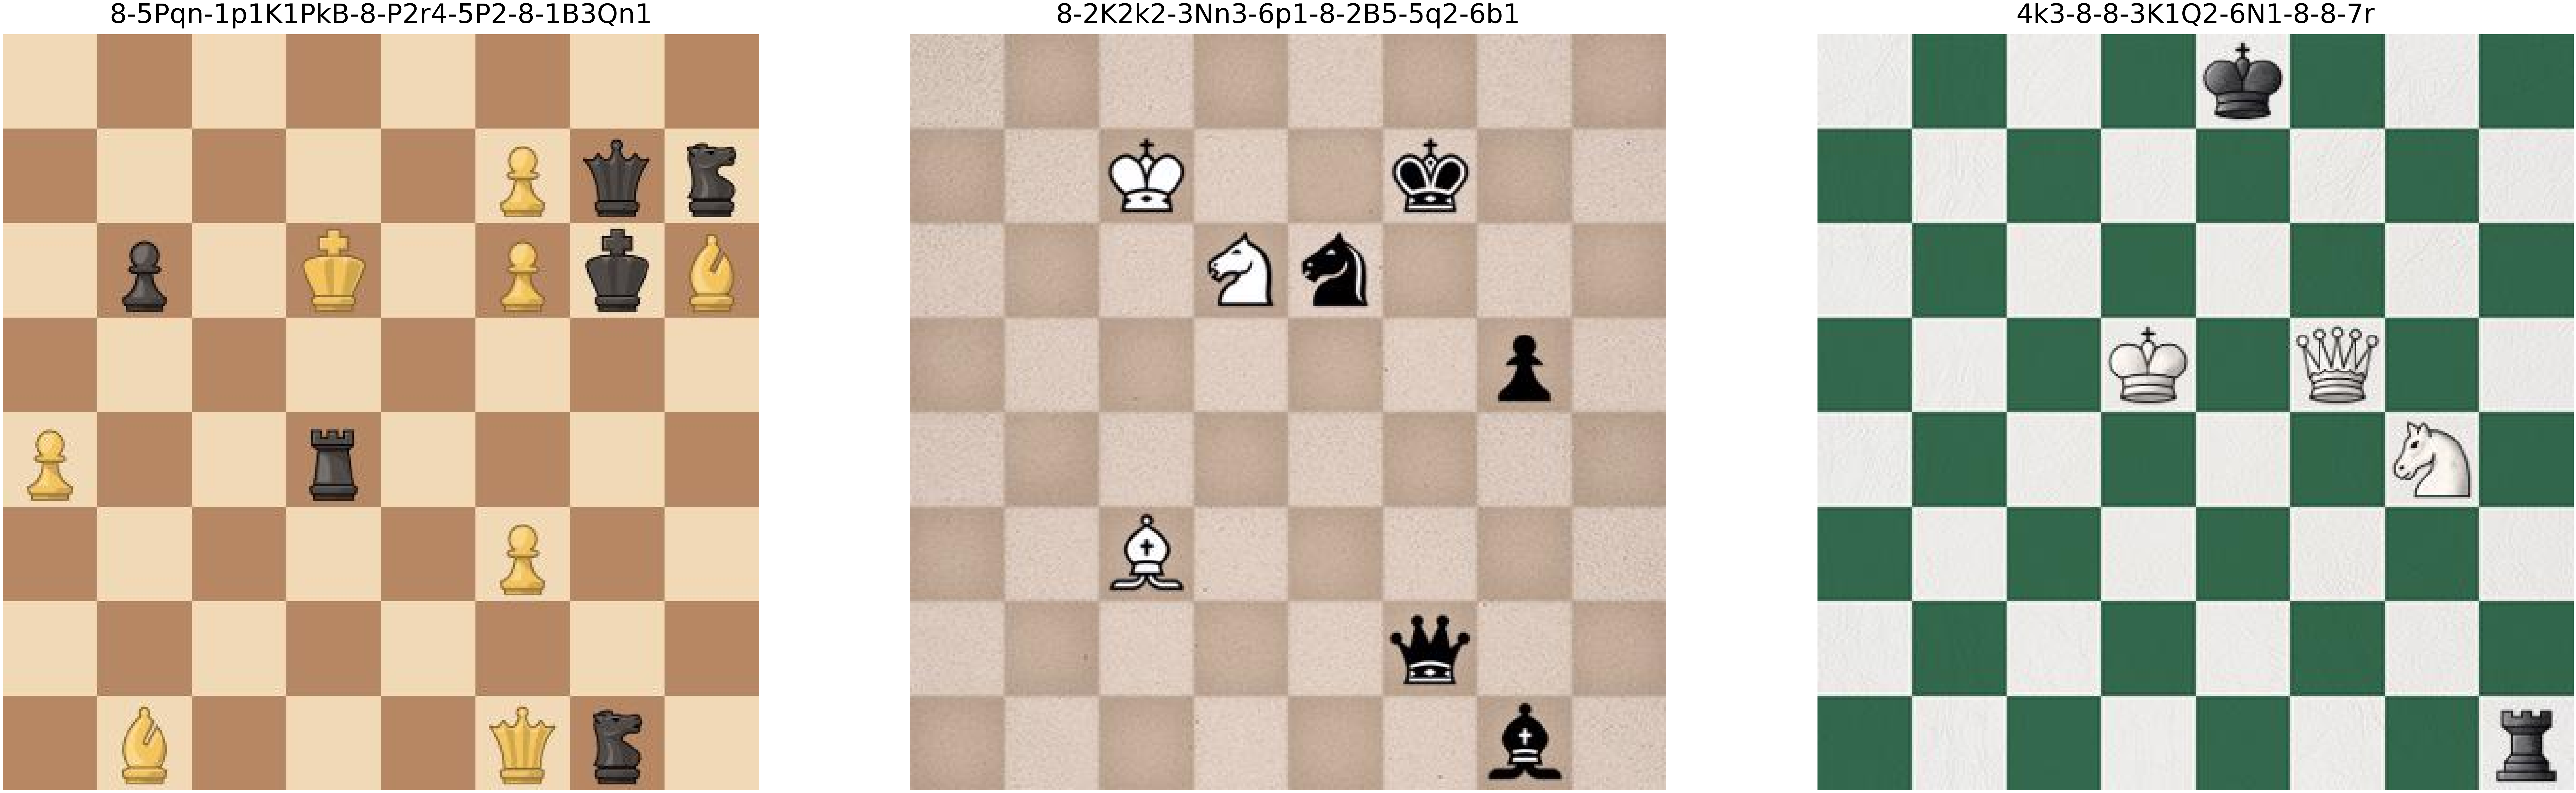

In [9]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))

for i in range(0,3):
    axarr[i].set_title(fen_from_filename(train[i]), fontsize=70, pad=30)
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

# Preprocessing

Preprocessing: The onehot_from_fen function converts the FEN labels into one-hot encoded vectors. The process_image function downsamples the images and divides them into smaller square tiles for CNN input.

In [12]:
def train_gen(features, labels, batch_size):
    for i, img in enumerate(features):
        y = onehot_from_fen(fen_from_filename(img))
        x = process_image(img)
        yield x, y

def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

# Model

Model: The CNN model is created using the Sequential API from Keras with multiple convolutional and fully connected layers. The model is compiled with the categorical cross-entropy loss and the Adam optimizer.

Model and Hyperparameters

The CNN model is designed with three convolutional layers with 32 filters each, followed by a flatten layer and a fully connected layer with 128 units. A dropout layer with a rate of 0.4 is added to reduce overfitting. The final layer uses the softmax activation function for multi-class classification. The model is trained with the categorical cross-entropy loss and the Adam optimizer.

In [21]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(25, 25, 3), activation='relu', kernel_initializer='he_normal'))
model.add(layers.Conv2D(32, (3, 3), input_shape=(25, 25, 3), activation='relu', kernel_initializer='he_normal'))
model.add(layers.Conv2D(32, (3, 3), input_shape=(25, 25, 3), activation='relu', kernel_initializer='he_normal'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 23, 23, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 32)        9248      
                                                                 
 flatten_1 (Flatten)         (None, 11552)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1478784   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 13)               

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
es = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='min', 
    verbose=1)

Training: The model is trained using a custom generator function (train_gen) that yields training batches of images and labels. Early stopping is applied to prevent overfitting.

In [24]:
model.fit_generator(train_gen(train, None, 64), steps_per_epoch=train_size, callbacks=es)

10000/10000 [==============================] - 778s 78ms/step - loss: 0.0233 - accuracy: 0.9942


In [27]:
# Save the model to a file
save_model(model, "model.h5")

# Evaluation

Evaluation: The model's performance is evaluated on the test data by calculating the final accuracy. The predicted FEN labels and ground truth FEN labels are compared, and a confusion matrix is generated.

In [28]:
res = (
  model.predict_generator(pred_gen(test, 64), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

In [29]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.99900%


In [37]:
test_fens

array(['3BR3-6b1-K4pN1-r7-8-3k4-5QB1-1br2r2',
       '8-4Br1N-4r1r1-3b3B-4n1r1-4k3-K1n1pQ2-R7',
       '3kQ3-5bR1-3B1R2-4n3-2RP4-2P5-Kp5B-1N6', ...,
       '3r4-8-8-2n5-PK4b1-1r2R3-2r1k3-3Q2n1',
       '8-2R5-3b1k1P-6bQ-8-1p6-1K3B2-3b1N2',
       'b3r1k1-3P4-5p2-6b1-1B6-3n4-3K4-7n'], dtype='<U43')

In [40]:
confusion_matrix(test_fens, pred_fens)

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

Display: The display_with_predicted_fen function displays an image along with its predicted FEN label using the trained model.

In [ ]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

2/2 [==============================] - 0s 7ms/step


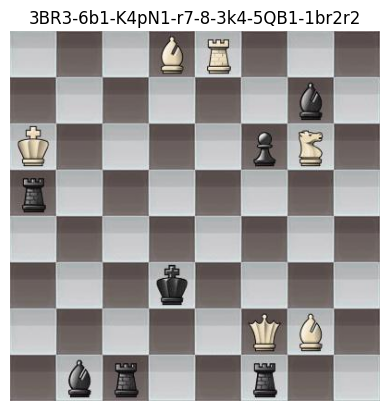

2/2 [==============================] - 0s 6ms/step


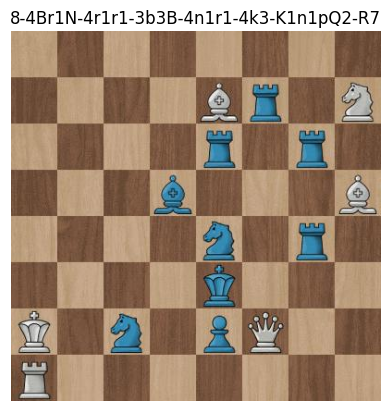

2/2 [==============================] - 0s 10ms/step


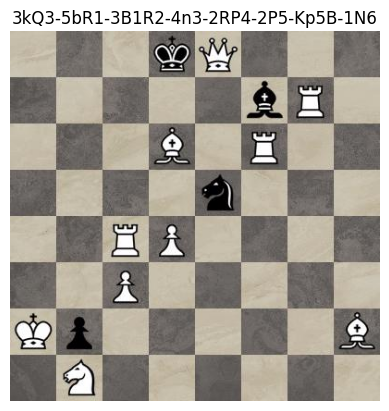

In [31]:
display_with_predicted_fen(test[0])
display_with_predicted_fen(test[1])
display_with_predicted_fen(test[2])

Performances

The model achieved an impressive final accuracy of 99.9%. The confusion matrix shows that all the test images were predicted correctly, demonstrating the model's high accuracy in predicting the FEN labels for the chessboard images.

Conclusion 

In conclusion, the image processing notebook presented an efficient approach to predict chess positions from images using FEN. The model, a CNN, achieved an impressive accuracy of 99.9% on the test data, successfully identifying FEN labels for chessboard images. The project demonstrates the power of CNNs in image classification tasks and provides valuable insights into handling complex image data. 

Thank you for the interesting assignment!